Paper Reference : https://j-innovative.org/index.php/Innovative/article/download/15199/10372/26113

In [1]:
import os
from modules.SignLanguageProcessor import load_and_preprocess_data,parse_frame

In [2]:
ROOT_PATH = ''
sequences,labels,label_map = load_and_preprocess_data(os.path.join(ROOT_PATH,'data'))

In [3]:
num_classes = len(label_map)

In [4]:
len(labels)

2155

In [5]:
sequences.shape

(2155, 3, 61, 3)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [7]:
import numpy as np
def normalize_landmark_data(X):
    """
    Normalize the landmark features (x, y) to have zero mean and unit variance across the training set.
    Assumes X shape is (N, F, L, T), where F=3 (x, y, vis).
    """
    X = X.copy()
    # Flatten across all samples, landmarks, and frames
    x_vals = X[:, 0, :, :].flatten()
    y_vals = X[:, 1, :, :].flatten()

    # Compute mean and std
    x_mean, x_std = np.mean(x_vals), np.std(x_vals)
    y_mean, y_std = np.mean(y_vals), np.std(y_vals)

    # Normalize
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std

    return X, (x_mean, x_std), (y_mean, y_std)

def apply_normalization(X, x_mean, x_std, y_mean, y_std):
    X = X.copy()
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std
    return X


In [8]:
def reshape_frames_for_cnn(X, y):
    """
    Reshape a dataset of (N, F, L, T) into (N*T, L, F, 1) for Conv2D,
    where each frame becomes its own sample.

    Parameters:
    - X: np.ndarray of shape (N, F, L, T)
    - y: np.ndarray of shape (N,)

    Returns:
    - reshaped_X: np.ndarray of shape (N*T, L, F, 1)
    - reshaped_y: np.ndarray of shape (N*T,)
    """
    reshaped_X = []
    reshaped_y = []

    for sample, label in zip(X, y):
        T = sample.shape[-1]
        for t in range(T):
            frame = sample[:, :, t].T[..., np.newaxis] 
            reshaped_X.append(frame)
            reshaped_y.append(label)

    reshaped_X = np.array(reshaped_X)
    reshaped_y = np.array(reshaped_y)
    return reshaped_X, reshaped_y

In [9]:

X_train_norm, (x_mean, x_std), (y_mean, y_std) = normalize_landmark_data(X_train)
X_val_norm  = apply_normalization(X_val, x_mean, x_std, y_mean, y_std)
X_test_norm = apply_normalization(X_test, x_mean, x_std, y_mean, y_std)

X_train_cnn, y_train_cnn = reshape_frames_for_cnn(X_train_norm, y_train)
X_val_cnn, y_val_cnn     = reshape_frames_for_cnn(X_val_norm, y_val)
X_test_cnn, y_test_cnn   = reshape_frames_for_cnn(X_test_norm, y_test)

print(X_train_cnn.shape)  
print(y_train_cnn.shape)


(3879, 61, 3, 1)
(3879,)


In [10]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

(61, 3, 1)


In [11]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_cnn))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Input

cnn_model = Sequential([
    Input(input_shape),
    Conv2D(32, (3, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),
    Conv2D(64, (3, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = cnn_model.fit(train_ds,validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0944 - loss: 3.1221 - val_accuracy: 0.1462 - val_loss: 2.9218
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1402 - loss: 2.8520 - val_accuracy: 0.1895 - val_loss: 2.6704
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1794 - loss: 2.6196 - val_accuracy: 0.2390 - val_loss: 2.5055
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2369 - loss: 2.4423 - val_accuracy: 0.2962 - val_loss: 2.3516
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2607 - loss: 2.2877 - val_accuracy: 0.3364 - val_loss: 2.2037
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3066 - loss: 2.1756 - val_accuracy: 0.3735 - val_loss: 2.1106
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3574 - loss: 2.0495 - val_accuracy: 0.4269 - val_loss: 1.9843
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3685 - loss: 1.9700 - val_accuracy: 0.4408 - val_loss

In [14]:
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6347 - loss: 1.4002
Test Accuracy: 0.6326
Test Loss: 1.2936


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

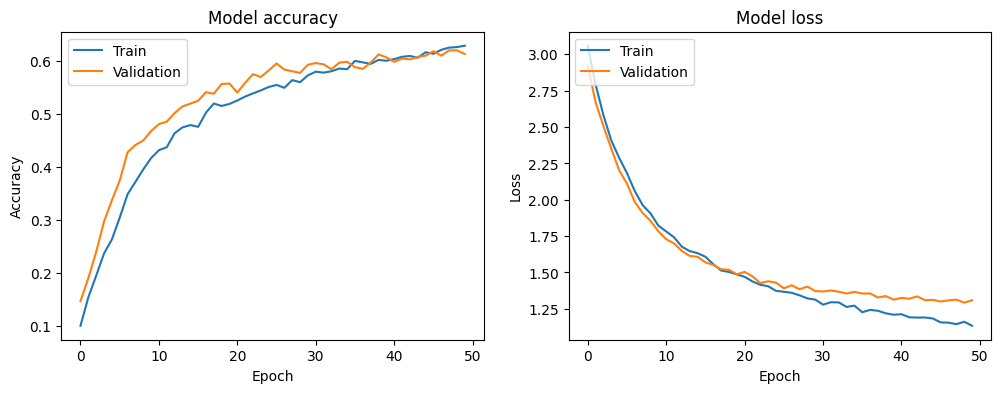

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

         baca      0.623     0.688     0.653        48
        bantu      0.811     0.769     0.789        39
        bapak      0.730     0.600     0.659        45
buangairkecil      0.625     0.625     0.625        24
         buat      0.895     0.667     0.764        51
         halo      0.507     0.617     0.556        60
          ibu      1.000     0.389     0.560        18
         kamu      0.660     0.530     0.588        66
         maaf      0.683     0.651     0.667        63
        makan      0.765     0.510     0.612        51
          mau      0.720     0.857     0.783        63
         nama      0.614     0.680     0.646        75
         pagi      0.566     0.653     0.606        72
        paham      0.455     0.880     0.600        75
        sakit      1.000     0.500     0.667        12
    sama-sama      0.761     0.607     0.675        84
         saya      0.737     0.359     0.483        39
      sel

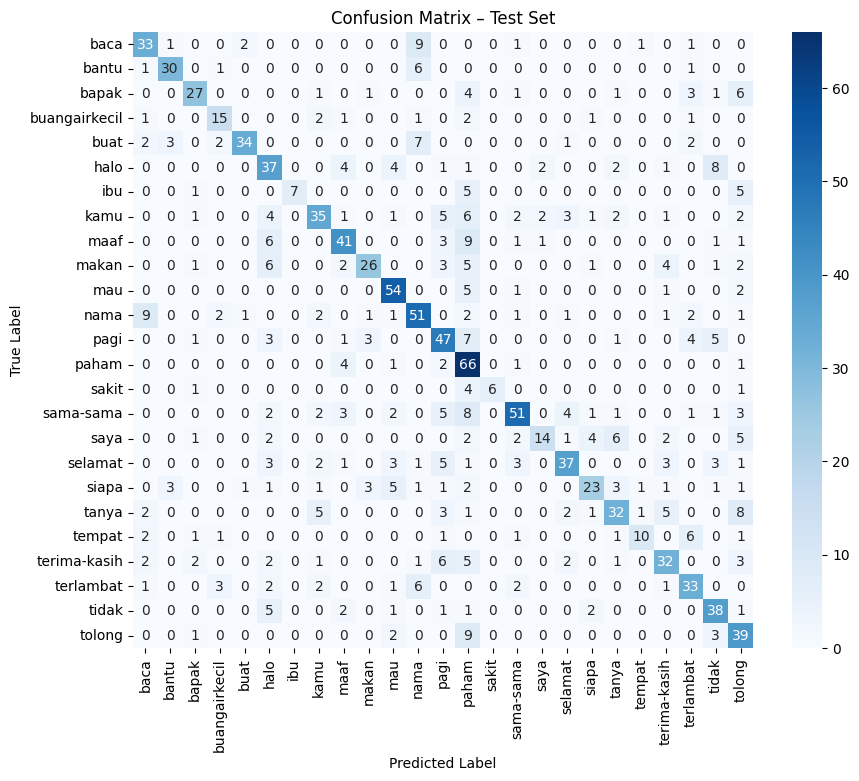

In [17]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = cnn_model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()